In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import lingam

from graphviz import Digraph
from lingam.utils import make_dot
from IPython.display import Image, display

In [2]:
# Edges
df_edges_plant = pd.read_csv("../data/SupplyGraph/Edges/Edges (Plant).csv")
df_edges_product_group = pd.read_csv("../data/SupplyGraph/Edges/Edges (Product Group).csv")
df_edges_product_subgroup = pd.read_csv("../data/SupplyGraph/Edges/Edges (Product Sub-Group).csv")
df_edges_storage_location = pd.read_csv("../data/SupplyGraph/Edges/Edges (Storage Location).csv")


# Nodes
df_nodes_productgroup_and_subgroup = pd.read_csv("../data/SupplyGraph/Nodes/Node Types (Product Group and Subgroup).csv")
df_nodes_plant_and_storage = pd.read_csv("../data/SupplyGraph/Nodes/Nodes Type (Plant & Storage).csv")
df_nodes = pd.read_csv("../data/SupplyGraph/Nodes/Nodes.csv")
df_nodes_index = pd.read_csv("../data/SupplyGraph/Nodes/NodesIndex.csv")


# # Temporal
df_delivery_to_distributor = pd.read_csv("../data/SupplyGraph/Temporal Data/Unit/Delivery To distributor.csv")
df_factory_issue = pd.read_csv("../data/SupplyGraph/Temporal Data/Unit/Factory Issue.csv")
df_production = pd.read_csv("../data/SupplyGraph/Temporal Data/Unit/Production.csv")
df_sales_order = pd.read_csv("../data/SupplyGraph/Temporal Data/Unit/Sales Order.csv")

## Node Definitions

- **Product**: `df_nodes` (contains all nodes including products)
- **ProductGroup**: `df_nodes_productgroup_and_subgroup` (Product Group types)
- **Production Facility**: `df_nodes_plant_and_storage` (Plant nodes)
- **Storage Location**: `df_nodes_plant_and_storage` (Storage nodes)
- **Distributor**: Not explicitly present in the loaded dataframes
- **SalesOrder**: `df_unit_sales_order`, `df_weight_sales_order` (temporal data)
- **Delivery**: `df_unit_delivery_to_distributor`, `df_weight_delivery_to_distributor` (temporal data)
- **FactoryIssue**: `df_unit_factory_issue`, `df_weight_factory_issue` (temporal data)

## Edge Definitions

- **Product → ProductGroup** (belongs to): `df_edges_product_group`, `df_edges_edgeindex_product_group`
- **Product → ProductionFacility** (produced at): `df_edges_plant`, `df_edges_edgeindex_plant`
- **Product → Storage** (stored at): `df_edges_storage_location`, `df_edges_edgeindex_storage_location`
- **Product → Distributor** (delivered to): `df_unit_delivery_to_distributor`, `df_weight_delivery_to_distributor`
- **ProductGroup → ProductionFacility** (uses raw materials): `df_edges_product_sub_group`, `df_edges_edgeindex_product_sub_group`
- **ProductionFacility → Storage** (sends): `df_edges_plant`, `df_edges_storage_location`
- **Storage → Distributor** (ships to): `df_unit_delivery_to_distributor`, `df_weight_delivery_to_distributor`
- **SalesOrder → Product** (requested for): `df_unit_sales_order`, `df_weight_sales_order`
- **ProductionFacility → Delivery** (dispatches): `df_unit_delivery_to_distributor`, `df_weight_delivery_to_distributor`
- **ProductionFacility → FactoryIssue** (logs issue): `df_unit_factory_issue`, `df_weight_factory_issue`
- **Delivery → Distributor** (received by): `df_unit_delivery_to_distributor`, `df_weight_delivery_to_distributor`
- **FactoryIssue → Storage** (issues to): `df_unit_factory_issue`, `df_weight_factory_issue`

**Note**: The `df_unit_production` and `df_weight_production` dataframes are loaded but not directly represented in this GraphViz diagram.

Collecting workspace informationFiltering to most relevant informationBased on the data quality reports and EDA summaries in your workspace, here's how these datasets relate to each other and how to maximize the data extraction:

## Dataset Relationships

### 1. **Core Graph Structure**
The datasets form a **heterogeneous supply chain graph** with multiple relationship types:

**Nodes (Products):**
- [`df_nodes`](Supply_Chain/SupplyGraph/Code/Developing heterogeneous graph/my_code_13-11-2025_03_tables_figuring_out_02.ipynb): 41 products (primary entities)
- [`df_nodes_productgroup_and_subgroup`](Supply_Chain/SupplyGraph/Code/Developing heterogeneous graph/my_code_13-11-2025_03_tables_figuring_out_02.ipynb): Product hierarchy classifications
- [`df_nodes_plant_and_storage`](Supply_Chain/SupplyGraph/Code/Developing heterogeneous graph/my_code_13-11-2025_03_tables_figuring_out_02.ipynb): 6,545 facilities (plants and storage locations)

**Edges (Relationships):**
- [`df_edges_plant`](Supply_Chain/SupplyGraph/Code/Developing heterogeneous graph/my_code_13-11-2025_03_tables_figuring_out_02.ipynb): 1,647 edges connecting products to plants (co-production relationships)
- [`df_edges_product_group`](Supply_Chain/SupplyGraph/Code/Developing heterogeneous graph/my_code_13-11-2025_03_tables_figuring_out_02.ipynb): 188 edges for product group membership
- [`df_edges_product_subgroup`](Supply_Chain/SupplyGraph/Code/Developing heterogeneous graph/my_code_13-11-2025_03_tables_figuring_out_02.ipynb): 52 edges for sub-group classification
- [`df_edges_storage_location`](Supply_Chain/SupplyGraph/Code/Developing heterogeneous graph/my_code_13-11-2025_03_tables_figuring_out_02.ipynb): 3,046 edges for storage co-location

### 2. **Temporal Dimension**
Each temporal dataset has **221 time steps × 42 products**:

**Flow Types:**
- [`df_production`](Supply_Chain/SupplyGraph/Code/Developing heterogeneous graph/my_code_13-11-2025_03_tables_figuring_out_02.ipynb): Production at facilities
- [`df_sales_order`](Supply_Chain/SupplyGraph/Code/Developing heterogeneous graph/my_code_13-11-2025_03_tables_figuring_out_02.ipynb): Customer demand
- [`df_factory_issue`](Supply_Chain/SupplyGraph/Code/Developing heterogeneous graph/my_code_13-11-2025_03_tables_figuring_out_02.ipynb): Internal transfers
- [`df_delivery_to_distributor`](Supply_Chain/SupplyGraph/Code/Developing heterogeneous graph/my_code_13-11-2025_03_tables_figuring_out_02.ipynb): Outbound shipments

## Maximum Data Extraction Strategy



In [3]:
# 1. BUILD UNIFIED HETEROGENEOUS GRAPH
def build_unified_graph():
    """
    Combine all edge types into a single heterogeneous graph
    """
    G = nx.MultiGraph()  # Allow multiple edge types between nodes
    
    # Add nodes with attributes
    for _, row in df_nodes_plant_and_storage.iterrows():
        G.add_node(
            row['Node'], 
            node_type='product',
            plant=row.get('Plant'),
            storage=row.get('Storage Location'),
            group=None,
            subgroup=None
        )
    
    # Add edges with relationship types
    edge_datasets = {
        'co_production': df_edges_plant,
        'product_group': df_edges_product_group,
        'subgroup': df_edges_product_subgroup,
        'co_location': df_edges_storage_location
    }
    
    for rel_type, edge_df in edge_datasets.items():
        for _, edge in edge_df.iterrows():
            G.add_edge(
                edge['node1'], 
                edge['node2'],
                relationship=rel_type,
                facility=edge.get('Plant') or edge.get('Storage Location'),
                group_code=edge.get('GroupCode'),
                subgroup_code=edge.get('SubGroupCode')
            )
    
    return G


# 2. ENRICH WITH TEMPORAL FEATURES
def add_temporal_features(G):
    """
    Add aggregated temporal statistics to nodes
    """
    temporal_dfs = {
        'production': df_production,
        'sales': df_sales_order,
        'factory_issue': df_factory_issue,
        'delivery': df_delivery_to_distributor
    }
    
    for node in G.nodes():
        if node in df_production.columns:
            for name, df in temporal_dfs.items():
                # Aggregate statistics
                G.nodes[node][f'{name}_total'] = df[node].sum()
                G.nodes[node][f'{name}_mean'] = df[node].mean()
                G.nodes[node][f'{name}_std'] = df[node].std()
                G.nodes[node][f'{name}_trend'] = np.polyfit(
                    range(len(df)), df[node], 1
                )[0]  # Linear trend slope
    
    return G


# 3. CREATE TEMPORAL SNAPSHOT GRAPHS
def create_temporal_snapshots(num_snapshots=10):
    """
    Create graph snapshots at different time windows
    """
    snapshots = []
    window_size = len(df_production) // num_snapshots
    
    for i in range(num_snapshots):
        start_idx = i * window_size
        end_idx = start_idx + window_size
        
        # Get temporal data for this window
        window_data = {
            'production': df_production.iloc[start_idx:end_idx],
            'sales': df_sales_order.iloc[start_idx:end_idx],
            'factory_issue': df_factory_issue.iloc[start_idx:end_idx],
            'delivery': df_delivery_to_distributor.iloc[start_idx:end_idx]
        }
        
        # Build graph with window-specific features
        G_snapshot = build_unified_graph()
        
        # Add temporal features for this window
        for node in G_snapshot.nodes():
            if node in df_production.columns:
                for name, df in window_data.items():
                    G_snapshot.nodes[node][f'{name}_total'] = df[node].sum()
        
        snapshots.append(G_snapshot)
    
    return snapshots


# 4. EXTRACT MULTI-LEVEL FEATURES (FIXED FOR MULTIGRAPH)
def extract_comprehensive_features(G):
    """
    Extract node, edge, and graph-level features
    Convert to simple graph for metrics that don't support multigraph
    """
    features = {
        'node_features': {},
        'edge_features': {},
        'graph_features': {}
    }
    
    # Convert to simple graph for calculating metrics
    G_simple = nx.Graph(G)
    
    # Calculate centrality metrics on simple graph
    betweenness = nx.betweenness_centrality(G_simple)
    clustering = nx.clustering(G_simple)
    
    # Node-level features
    for node in G.nodes():
        features['node_features'][node] = {
            'degree': G.degree(node),  # Total degree including multi-edges
            'unique_neighbors': G_simple.degree(node),  # Unique neighbors
            'clustering': clustering[node],
            'betweenness': betweenness[node],
            **G.nodes[node]  # All temporal features
        }
    
    # Edge-level features
    for u, v, key, data in G.edges(data=True, keys=True):
        features['edge_features'][(u, v, key)] = {
            'relationship_type': data['relationship'],
            'facility': data.get('facility'),
            'weight': 1
        }
    
    # Graph-level features
    features['graph_features'] = {
        'num_nodes': G.number_of_nodes(),
        'num_edges': G.number_of_edges(),
        'num_unique_edges': G_simple.number_of_edges(),
        'density': nx.density(G_simple),
        'avg_clustering': nx.average_clustering(G_simple),
        'num_components': nx.number_connected_components(G_simple)
    }
    
    return features


# 5. BUILD PRODUCT SIMILARITY NETWORK
def build_product_similarity_network(threshold=0.7):
    """
    Create edges based on temporal correlation
    """
    G_similarity = nx.Graph()
    
    # Calculate correlations across all temporal data
    all_temporal = pd.concat([
        df_production.set_index('Date'),
        df_sales_order.set_index('Date'),
        df_factory_issue.set_index('Date'),
        df_delivery_to_distributor.set_index('Date')
    ], axis=0).groupby(level=0).sum()
    
    corr_matrix = all_temporal.corr()
    
    # Add edges for highly correlated products
    for i, product1 in enumerate(corr_matrix.columns):
        for j, product2 in enumerate(corr_matrix.columns[i+1:], i+1):
            correlation = corr_matrix.iloc[i, j]
            if abs(correlation) > threshold:
                G_similarity.add_edge(
                    product1, 
                    product2,
                    weight=correlation,
                    edge_type='temporal_correlation'
                )
    
    return G_similarity


# 6. USAGE EXAMPLE
try:
    # Build complete graph
    G_unified = build_unified_graph()
    G_unified = add_temporal_features(G_unified)
    
    # Get temporal snapshots for dynamic analysis
    snapshots = create_temporal_snapshots(num_snapshots=10)
    
    # Extract all features
    features = extract_comprehensive_features(G_unified)
    
    # Build similarity network
    G_similarity = build_product_similarity_network(threshold=0.7)
    
    print(f"Unified Graph: {G_unified.number_of_nodes()} nodes, {G_unified.number_of_edges()} edges")
    print(f"Similarity Network: {G_similarity.number_of_nodes()} nodes, {G_similarity.number_of_edges()} edges")
    print(f"Created {len(snapshots)} temporal snapshots")
    
    # Show sample node features
    print("\nSample Node Features:")
    sample_node = list(features['node_features'].keys())[0]
    print(f"{sample_node}: {features['node_features'][sample_node]}")
    
except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()

Unified Graph: 40 nodes, 4933 edges
Similarity Network: 21 nodes, 22 edges
Created 10 temporal snapshots

Sample Node Features:
POV002L09P: {'degree': 445, 'unique_neighbors': 39, 'clustering': 0.8704453441295547, 'betweenness': 0.0057447334323970705, 'node_type': 'product', 'plant': 2103, 'storage': 330.0, 'group': None, 'subgroup': None, 'production_total': np.int64(125087), 'production_mean': np.float64(566.0045248868778), 'production_std': np.float64(783.90629366791), 'production_trend': np.float64(1.1132300132300137), 'sales_total': np.float64(121369.0), 'sales_mean': np.float64(549.1809954751131), 'sales_std': np.float64(563.3689278882122), 'sales_trend': np.float64(0.4188977953683842), 'factory_issue_total': np.float64(120297.78), 'factory_issue_mean': np.float64(544.3338461538461), 'factory_issue_std': np.float64(495.7169275504316), 'factory_issue_trend': np.float64(0.779174729562964), 'delivery_total': np.float64(120944.0), 'delivery_mean': np.float64(547.2579185520362), 'deli



## Key Insights for Maximum Data Extraction

1. **Multi-relational Structure**: Products are connected through 4 different relationship types (co-production, group membership, sub-group, co-location)

2. **Temporal Dynamics**: 221 time steps provide rich temporal patterns for forecasting and causal analysis

3. **Hierarchical Information**: Product groups → Products → Facilities creates multi-level analysis opportunities

4. **Complete Coverage**: 100% data completeness (from [eda_summary.csv](Supply_Chain/SupplyGraph/Code/Developing heterogeneous graph/eda_summary.csv)) means no missing data to handle

5. **Network Metrics**: With 4,933 total edges across 41 products, the graph is highly connected (dense supply chain)

This approach allows you to leverage:
- **Static graph structure** for relationship analysis
- **Temporal sequences** for demand forecasting and causality
- **Multi-level features** for comprehensive predictions
- **Dynamic snapshots** for time-varying graph neural networks

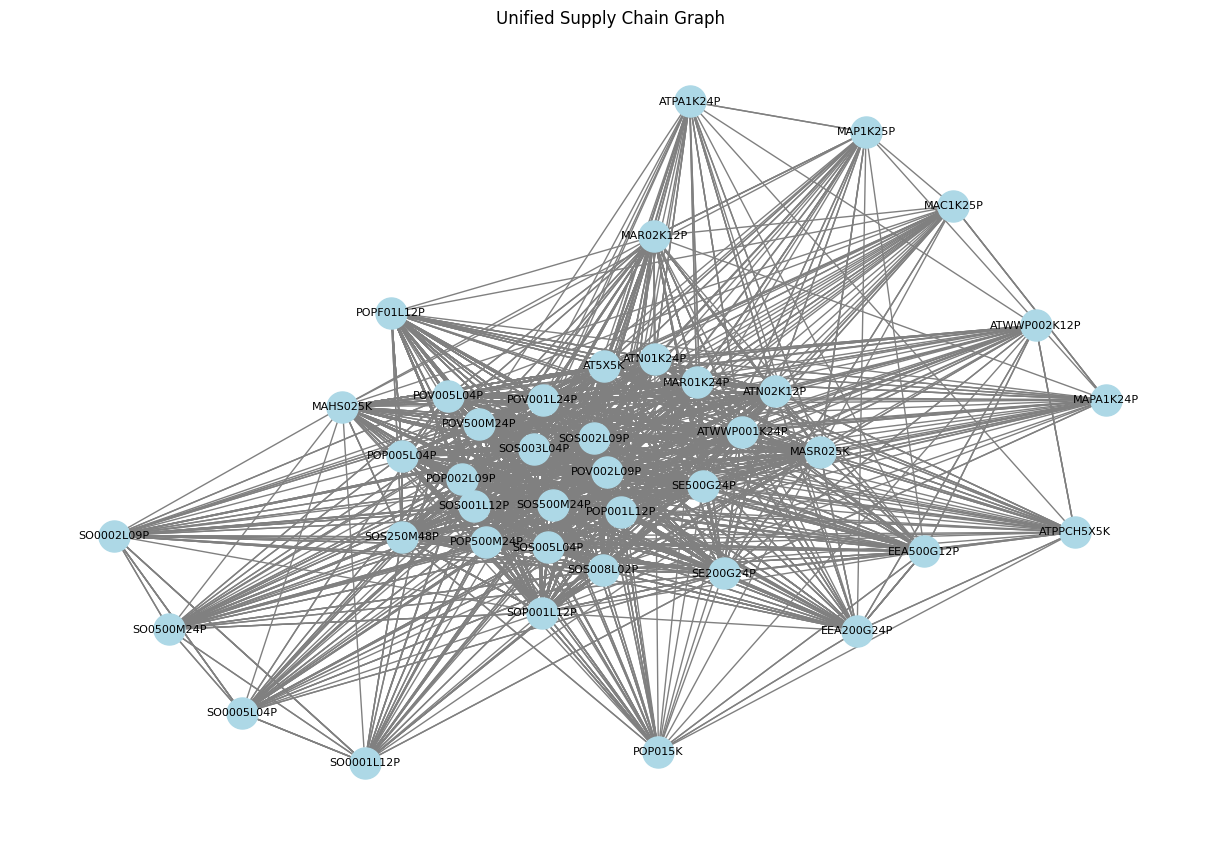

In [4]:
# Visualize the unified graph

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_unified)  # Use spring layout for positioning
nx.draw(G_unified, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=8, edge_color='gray')
plt.title('Unified Supply Chain Graph')
plt.show()

Facility and Classification Info:


,Attribute,Value
0,Product,SOS005L04P
1,Production Plants,"2103, 2111, 2112, 2114, 2115, 2116, 2117, 2118..."
2,Storage Locations,"2030.0, 1130.0, 2130.0, 1930.0, 1430.0, 1630.0..."
3,Product Group,S
4,Product Subgroup,SOS



Subgraph Nodes:


,Node,Type
0,POV002L09P,Related
1,SOS001L12P,Related
2,POP002L09P,Related
3,POP001L12P,Related
4,POV001L24P,Related
5,SOS005L04P,Product
6,POP500M24P,Related
7,ATN01K24P,Related
8,ATN02K12P,Related
9,MAR02K12P,Related



Subgraph Edges (limited):


,Source,Target,Relationship,Facility
0,POV002L09P,SOS005L04P,co_production,2103.0
1,POV002L09P,SOS005L04P,co_production,2111.0
2,POV002L09P,SOS005L04P,co_production,2112.0
3,POV002L09P,SOS005L04P,co_location,330.0
4,POV002L09P,SOS005L04P,co_location,1130.0
5,POV002L09P,SOS005L04P,co_location,1230.0
6,POV002L09P,POV001L24P,product_group,NaN
7,POV002L09P,POV001L24P,subgroup,NaN
8,POV002L09P,POV500M24P,product_group,NaN
9,POV002L09P,POV500M24P,subgroup,NaN



Temporal Features for SOS005L04P:


,Feature,Value
0,production_total,1.482784e+06
1,production_mean,6.709430e+03
2,production_std,4.802587e+03
3,production_trend,-2.928006e+01
4,sales_total,1.521854e+06
5,sales_mean,6.886215e+03
6,sales_std,6.104767e+03
7,sales_trend,-2.842134e+01
8,factory_issue_total,1.476175e+06
9,factory_issue_mean,6.679526e+03


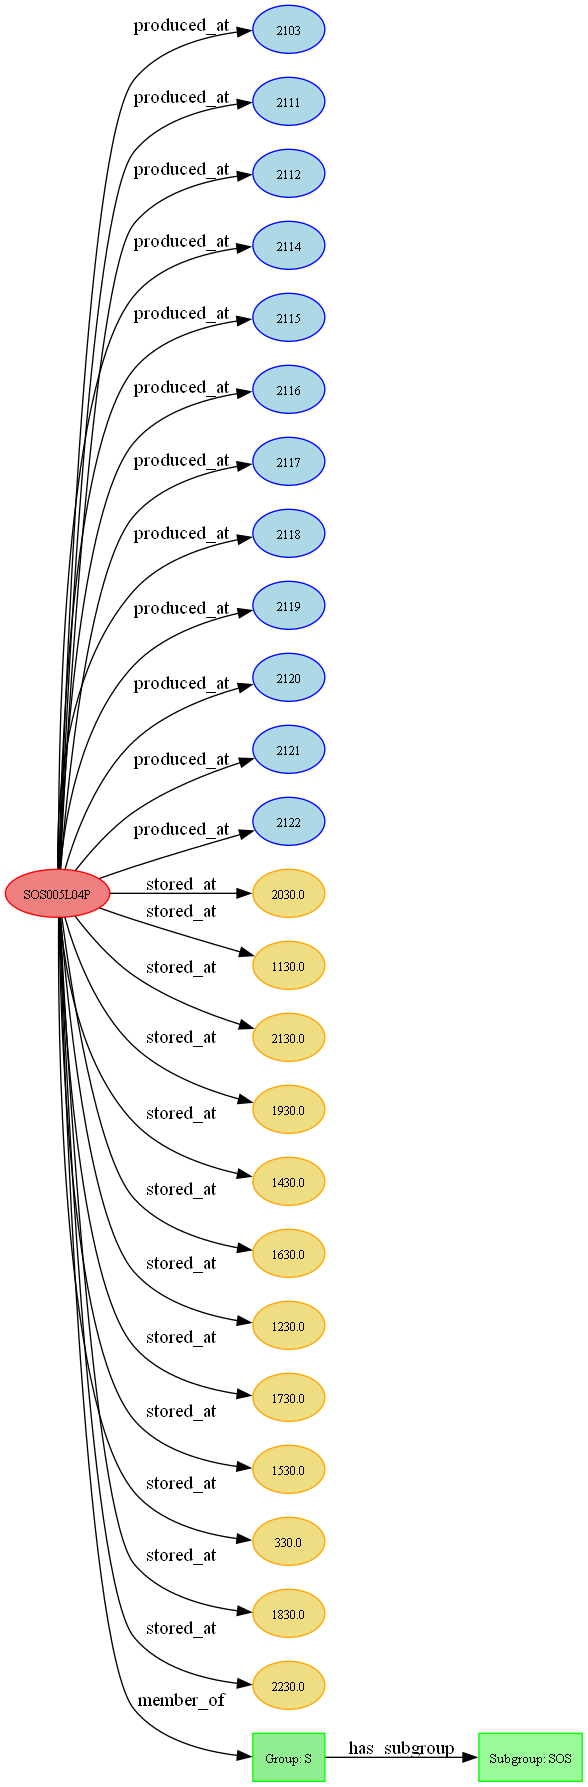

In [5]:
# Assuming G_unified is built and enriched
product_node = 'SOS005L04P'
max_edges_per_type = 3  # Default: 3 edges per relationship type

# 1. Get facility and classification info as DataFrame
def get_product_facilities_df(product_name):
    plants = df_edges_plant[df_edges_plant['node1'] == product_name]['Plant'].unique()
    storage = df_nodes_plant_and_storage[df_nodes_plant_and_storage['Node'] == product_name]['Storage Location'].unique()
    product_info = df_nodes_productgroup_and_subgroup[df_nodes_productgroup_and_subgroup['Node'] == product_name]
    
    data = {
        'Attribute': ['Product', 'Production Plants', 'Storage Locations', 'Product Group', 'Product Subgroup'],
        'Value': [
            product_name,
            ', '.join(str(p) for p in plants) if len(plants) > 0 else 'None',
            ', '.join(str(s) for s in storage) if len(storage) > 0 else 'None',
            product_info['Group'].values[0] if not product_info.empty else 'None',
            product_info['Sub-Group'].values[0] if not product_info.empty else 'None'
        ]
    }
    return pd.DataFrame(data)

facility_df = get_product_facilities_df(product_node)
print("Facility and Classification Info:")
display(facility_df)

# 2. Get subgraph and relations as DataFrames
neighbors = list(G_unified.neighbors(product_node))
nodes_to_include = [product_node] + neighbors
subgraph = G_unified.subgraph(nodes_to_include)

# Nodes DataFrame
nodes_df = pd.DataFrame({
    'Node': list(subgraph.nodes()),
    'Type': ['Product' if n == product_node else 'Related' for n in subgraph.nodes()]
})
print("\nSubgraph Nodes:")
display(nodes_df)

# Edges DataFrame with limit per type
edges_data = []
edge_count = {}
for u, v, key, data in subgraph.edges(data=True, keys=True):
    rel = data['relationship']
    if rel not in edge_count:
        edge_count[rel] = 0
    if edge_count[rel] < max_edges_per_type:
        edges_data.append({
            'Source': u,
            'Target': v,
            'Relationship': rel,
            'Facility': data.get('facility', 'N/A')
        })
        edge_count[rel] += 1

edges_df = pd.DataFrame(edges_data)
print("\nSubgraph Edges (limited):")
display(edges_df)

# 3. Get temporal features as DataFrame
if product_node in G_unified.nodes():
    temporal_features = {k: v for k, v in G_unified.nodes[product_node].items() if 'total' in k or 'mean' in k or 'std' in k or 'trend' in k}
    temporal_df = pd.DataFrame(list(temporal_features.items()), columns=['Feature', 'Value'])
    print(f"\nTemporal Features for {product_node}:")
    display(temporal_df)


# 4. Visualization
idx = facility_df.set_index('Attribute')['Value']

product = idx.get('Product', product_node)
plants = [] if idx.get('Production Plants', 'None') in (None, 'None', '') else [p.strip() for p in idx['Production Plants'].split(',') if p.strip()]
storages = [] if idx.get('Storage Locations', 'None') in (None, 'None', '') else [s.strip() for s in idx['Storage Locations'].split(',') if s.strip()]
group = None if idx.get('Product Group', 'None') in (None, 'None', '') else idx['Product Group']
subgroup = None if idx.get('Product Subgroup', 'None') in (None, 'None', '') else idx['Product Subgroup']

# Create Graphviz diagram with only connected nodes
dot = Digraph(comment='Facility & Classification Subgraph')
dot.attr(rankdir='LR', size='20,200')
dot.attr('node', style='filled', fontsize='10')

# Add main product node
dot.node(product, product, fillcolor='lightcoral', color='red')

# Add facility nodes and edges (only if present)
for p in plants:
    dot.node(p, p, fillcolor='lightblue', color='blue')
    dot.edge(product, p, label='produced_at')

for s in storages:
    dot.node(s, s, fillcolor='lightgoldenrod', color='orange')
    dot.edge(product, s, label='stored_at')

# Add classification nodes and edges
if group:
    dot.node(group, f'Group: {group}', fillcolor='lightgreen', color='green', shape='box')
    dot.edge(product, group, label='member_of')

if subgroup:
    dot.node(subgroup, f'Subgroup: {subgroup}', fillcolor='palegreen', color='green', shape='box')
    # connect subgroup to group if both exist, else connect product to subgroup
    if group:
        dot.edge(group, subgroup, label='has_subgroup')
    else:
        dot.edge(product, subgroup, label='member_of_subgroup')

# If no edges were added, add a small note node
if not (plants or storages or group or subgroup):
    dot.node('note', 'No connected facilities or classifications found', shape='note', fillcolor='lightgrey')

# Render and display
out_path = '../figures/facility_subgraph'
dot.render(out_path, format='png', cleanup=True)
display(Image(f'{out_path}.png'))

Collecting workspace informationBased on your SupplyGraph dataset, here's how the **ordering process** works in the supply chain workflow:

## Sales Order Process Flow

The ordering process involves these key datasets and stages:

### 1. **Order Initiation (Sales Order)**
- **Dataset**: [`df_sales_order`](Supply_Chain/SupplyGraph/Code/Developing heterogeneous graph/my_code_13-11-2025_03_tables_figuring_out_02.ipynb) (221 timesteps × 42 products)
- **What it captures**: Customer demand/orders for each product over time
- **Temporal range**: 2023-01-01 to 2023-08-07 (from the CSV excerpts)
- **Structure**: Each row = date, each column = product SKU (e.g., `SOS008L02P`, `SOS005L04P`, etc.)

### 2. **Production Response**
- **Dataset**: [`df_production`](Supply_Chain/SupplyGraph/Code/Developing heterogeneous graph/my_code_13-11-2025_03_tables_figuring_out_02.ipynb)
- **What it captures**: Units produced at manufacturing facilities in response to orders
- **Connection**: Links to [`df_edges_plant`](Supply_Chain/SupplyGraph/Code/Developing heterogeneous graph/my_code_13-11-2025_03_tables_figuring_out_02.ipynb) (which products are made at which plants)

### 3. **Internal Transfer (Factory Issue)**
- **Dataset**: [`df_factory_issue`](Supply_Chain/SupplyGraph/Code/Developing heterogeneous graph/my_code_13-11-2025_03_tables_figuring_out_02.ipynb)
- **What it captures**: Movement of products from production facilities to storage locations
- **Connection**: Links production facilities ([`df_nodes_plant_and_storage`](Supply_Chain/SupplyGraph/Code/Developing heterogeneous graph/my_code_13-11-2025_03_tables_figuring_out_02.ipynb)) to storage areas

### 4. **Order Fulfillment (Delivery)**
- **Dataset**: [`df_delivery_to_distributor`](Supply_Chain/SupplyGraph/Code/Developing heterogeneous graph/my_code_13-11-2025_03_tables_figuring_out_02.ipynb)
- **What it captures**: Final shipment from storage/plant to distributors/customers
- **Connection**: Uses [`df_edges_storage_location`](Supply_Chain/SupplyGraph/Code/Developing heterogeneous graph/my_code_13-11-2025_03_tables_figuring_out_02.ipynb) (3,046 edges) to track which products ship from which locations

## Complete Ordering Workflow



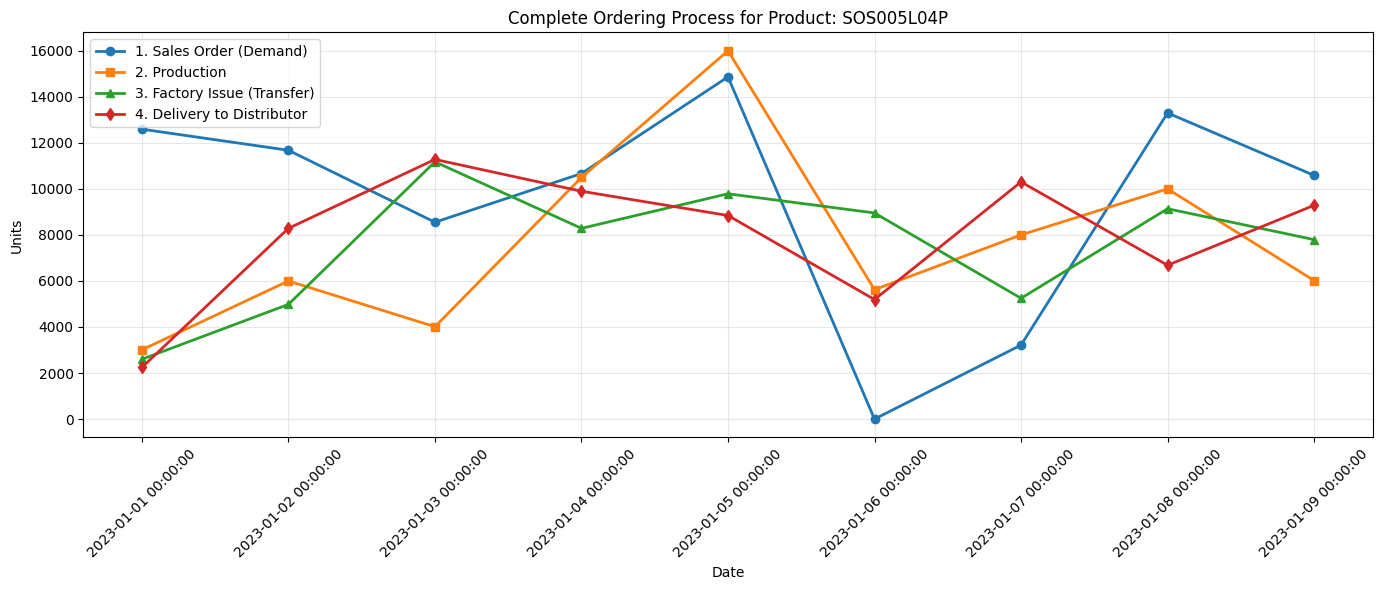

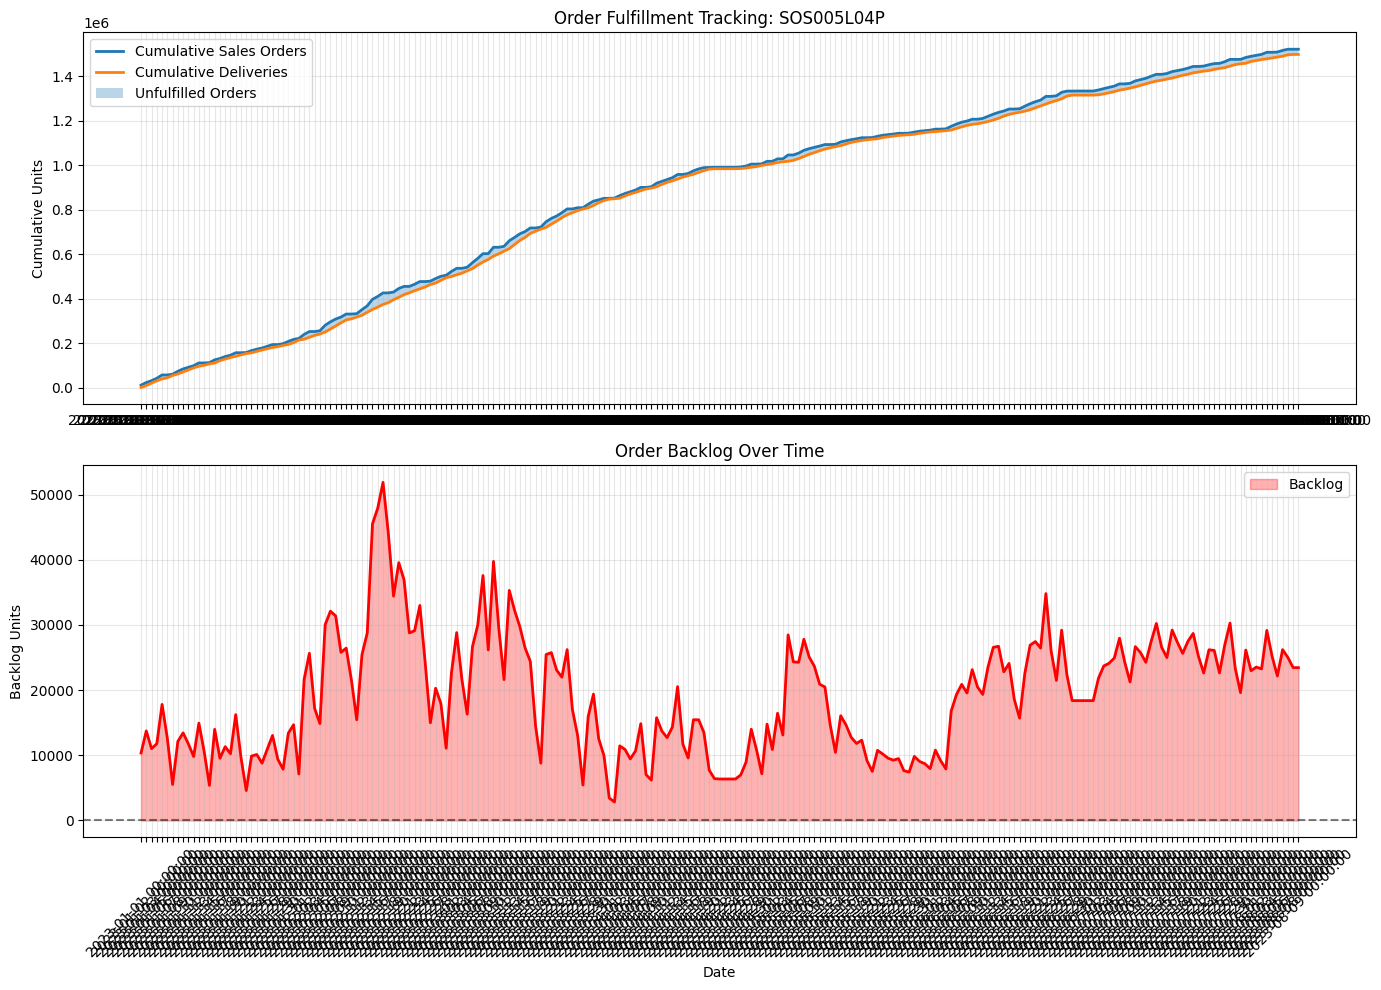


Product Facility Information:
{'product': 'SOS005L04P', 'production_plants': [np.int64(2103), np.int64(2111), np.int64(2112), np.int64(2114), np.int64(2115), np.int64(2116), np.int64(2117), np.int64(2118), np.int64(2119), np.int64(2120), np.int64(2121), np.int64(2122)], 'storage_locations': [np.float64(2030.0), np.float64(1130.0), np.float64(2130.0), np.float64(1930.0), np.float64(1430.0), np.float64(1630.0), np.float64(1230.0), np.float64(1730.0), np.float64(1530.0), np.float64(330.0), np.float64(1830.0), np.float64(2230.0)], 'product_group': 'S', 'product_subgroup': 'SOS'}

Sample Timeline Data:


,Date,Sales_Order,Production,Factory_Issue,Delivery
0,2023-01-01 00:00:00,12594.00,3008,2598.0,2241.00
1,2023-01-02 00:00:00,11677.00,6000,4982.0,8286.00
2,2023-01-03 00:00:00,8551.00,4012,11175.0,11279.75
3,2023-01-04 00:00:00,10667.25,10497,8286.0,9897.00
4,2023-01-05 00:00:00,14864.00,16000,9787.0,8843.25
5,2023-01-06 00:00:00,0.00,5623,8954.0,5193.00
6,2023-01-07 00:00:00,3216.00,8001,5247.0,10303.00
7,2023-01-08 00:00:00,13298.00,10000,9138.0,6683.00
8,2023-01-09 00:00:00,10586.50,6017,7796.0,9287.25



Order Fulfillment Statistics:
Average Backlog: 19153.01 units
Max Backlog: 51877.75 units
Order Fulfillment Rate: 98.46%


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

def visualize_ordering_process(product_name='SOS005L04P', start_date='2023-01-01', end_date='2023-02-01'):
    """
    Trace the complete ordering process for a specific product
    """
    # Filter date range
    mask = (df_sales_order['Date'] >= start_date) & (df_sales_order['Date'] <= end_date)
    
    # Extract data for the product
    sales_data = df_sales_order.loc[mask, ['Date', product_name]].rename(columns={product_name: 'Sales_Order'})
    production_data = df_production.loc[mask, ['Date', product_name]].rename(columns={product_name: 'Production'})
    factory_issue_data = df_factory_issue.loc[mask, ['Date', product_name]].rename(columns={product_name: 'Factory_Issue'})
    delivery_data = df_delivery_to_distributor.loc[mask, ['Date', product_name]].rename(columns={product_name: 'Delivery'})
    
    # Merge all data
    timeline = sales_data.merge(production_data, on='Date') \
                         .merge(factory_issue_data, on='Date') \
                         .merge(delivery_data, on='Date')
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 6))
    
    ax.plot(timeline['Date'], timeline['Sales_Order'], marker='o', label='1. Sales Order (Demand)', linewidth=2)
    ax.plot(timeline['Date'], timeline['Production'], marker='s', label='2. Production', linewidth=2)
    ax.plot(timeline['Date'], timeline['Factory_Issue'], marker='^', label='3. Factory Issue (Transfer)', linewidth=2)
    ax.plot(timeline['Date'], timeline['Delivery'], marker='d', label='4. Delivery to Distributor', linewidth=2)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Units')
    ax.set_title(f'Complete Ordering Process for Product: {product_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return timeline


def get_product_facilities(product_name):
    """
    Find which facilities handle a specific product
    """
    # Production facilities
    plants = df_edges_plant[df_edges_plant['node1'] == product_name]['Plant'].unique()
    
    # Storage locations
    storage = df_nodes_plant_and_storage[df_nodes_plant_and_storage['Node'] == product_name]['Storage Location'].unique()
    
    # Product classification
    product_info = df_nodes_productgroup_and_subgroup[df_nodes_productgroup_and_subgroup['Node'] == product_name]
    
    return {
        'product': product_name,
        'production_plants': list(plants),
        'storage_locations': list(storage),
        'product_group': product_info['Group'].values[0] if not product_info.empty else None,
        'product_subgroup': product_info['Sub-Group'].values[0] if not product_info.empty else None
    }


def analyze_order_fulfillment_lag(product_name='SOS005L04P'):
    """
    Calculate time lag between order placement and fulfillment
    """
    # Calculate cumulative values
    cumulative_sales = df_sales_order[product_name].cumsum()
    cumulative_delivery = df_delivery_to_distributor[product_name].cumsum()
    
    # Lag analysis
    lag_df = pd.DataFrame({
        'Date': df_sales_order['Date'],
        'Cumulative_Orders': cumulative_sales,
        'Cumulative_Deliveries': cumulative_delivery,
        'Backlog': cumulative_sales - cumulative_delivery
    })
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Cumulative comparison
    ax1.plot(lag_df['Date'], lag_df['Cumulative_Orders'], label='Cumulative Sales Orders', linewidth=2)
    ax1.plot(lag_df['Date'], lag_df['Cumulative_Deliveries'], label='Cumulative Deliveries', linewidth=2)
    ax1.fill_between(lag_df['Date'], lag_df['Cumulative_Orders'], lag_df['Cumulative_Deliveries'], alpha=0.3, label='Unfulfilled Orders')
    ax1.set_ylabel('Cumulative Units')
    ax1.set_title(f'Order Fulfillment Tracking: {product_name}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Backlog
    ax2.plot(lag_df['Date'], lag_df['Backlog'], color='red', linewidth=2)
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax2.fill_between(lag_df['Date'], 0, lag_df['Backlog'], where=(lag_df['Backlog'] > 0), 
                      color='red', alpha=0.3, label='Backlog')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Backlog Units')
    ax2.set_title('Order Backlog Over Time')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return lag_df


# Example usage
timeline = visualize_ordering_process('SOS005L04P', '2023-01-01', '2023-01-10')
facility_info = get_product_facilities('SOS005L04P')
lag_analysis = analyze_order_fulfillment_lag('SOS005L04P')

print("\nProduct Facility Information:")
print(facility_info)

print("\nSample Timeline Data:")
display(timeline.head(10))

print("\nOrder Fulfillment Statistics:")
print(f"Average Backlog: {lag_analysis['Backlog'].mean():.2f} units")
print(f"Max Backlog: {lag_analysis['Backlog'].max():.2f} units")
print(f"Order Fulfillment Rate: {(lag_analysis['Cumulative_Deliveries'].iloc[-1] / lag_analysis['Cumulative_Orders'].iloc[-1] * 100):.2f}%")



## Key Datasets Involved in Ordering

1. **Sales Order** ([`df_sales_order`](Supply_Chain/SupplyGraph/Code/Developing heterogeneous graph/my_code_13-11-2025_03_tables_figuring_out_02.ipynb)) → Customer demand
2. **Production** ([`df_production`](Supply_Chain/SupplyGraph/Code/Developing heterogeneous graph/my_code_13-11-2025_03_tables_figuring_out_02.ipynb)) → Manufacturing response
3. **Factory Issue** ([`df_factory_issue`](Supply_Chain/SupplyGraph/Code/Developing heterogeneous graph/my_code_13-11-2025_03_tables_figuring_out_02.ipynb)) → Internal logistics
4. **Delivery** ([`df_delivery_to_distributor`](Supply_Chain/SupplyGraph/Code/Developing heterogeneous graph/my_code_13-11-2025_03_tables_figuring_out_02.ipynb)) → Final fulfillment

## Structural Connections

- **Products** → **Plants**: [`df_edges_plant`](Supply_Chain/SupplyGraph/Code/Developing heterogeneous graph/my_code_13-11-2025_03_tables_figuring_out_02.ipynb) (1,647 edges)
- **Products** → **Storage**: [`df_edges_storage_location`](Supply_Chain/SupplyGraph/Code/Developing heterogeneous graph/my_code_13-11-2025_03_tables_figuring_out_02.ipynb) (3,046 edges)
- **Products** → **Groups**: [`df_edges_product_group`](Supply_Chain/SupplyGraph/Code/Developing heterogeneous graph/my_code_13-11-2025_03_tables_figuring_out_02.ipynb) (188 edges)

The ordering process flows: **Sales Order → Production → Factory Issue → Delivery**, with facility assignments determined by the edge datasets.

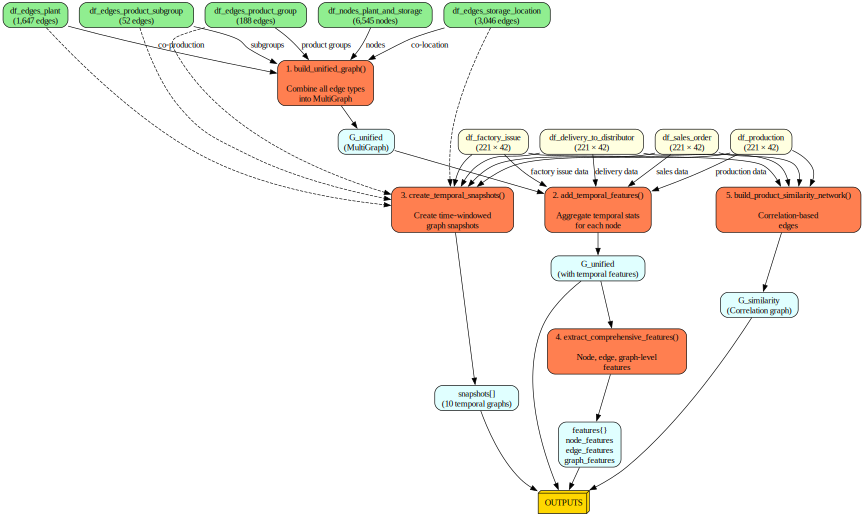

In [7]:
from graphviz import Digraph

# Create workflow diagram
workflow = Digraph('Supply_Chain_Workflow', comment='Data Processing Workflow')
workflow.attr(rankdir='TB', size='12,16')
workflow.attr('node', shape='box', style='rounded,filled', fillcolor='lightblue')

# Input Data
workflow.node('A1', 'df_edges_plant\n(1,647 edges)', fillcolor='lightgreen')
workflow.node('A2', 'df_edges_product_group\n(188 edges)', fillcolor='lightgreen')
workflow.node('A3', 'df_edges_product_subgroup\n(52 edges)', fillcolor='lightgreen')
workflow.node('A4', 'df_edges_storage_location\n(3,046 edges)', fillcolor='lightgreen')
workflow.node('A5', 'df_nodes_plant_and_storage\n(6,545 nodes)', fillcolor='lightgreen')

workflow.node('B1', 'df_production\n(221 × 42)', fillcolor='lightyellow')
workflow.node('B2', 'df_sales_order\n(221 × 42)', fillcolor='lightyellow')
workflow.node('B3', 'df_factory_issue\n(221 × 42)', fillcolor='lightyellow')
workflow.node('B4', 'df_delivery_to_distributor\n(221 × 42)', fillcolor='lightyellow')

# Method 1: Build Unified Graph
workflow.node('C1', '1. build_unified_graph()\n\nCombine all edge types\ninto MultiGraph', fillcolor='coral')
workflow.edge('A1', 'C1', label='co-production')
workflow.edge('A2', 'C1', label='product groups')
workflow.edge('A3', 'C1', label='subgroups')
workflow.edge('A4', 'C1', label='co-location')
workflow.edge('A5', 'C1', label='nodes')

workflow.node('C1_OUT', 'G_unified\n(MultiGraph)', fillcolor='lightcyan')
workflow.edge('C1', 'C1_OUT')

# Method 2: Add Temporal Features
workflow.node('C2', '2. add_temporal_features()\n\nAggregate temporal stats\nfor each node', fillcolor='coral')
workflow.edge('B1', 'C2', label='production data')
workflow.edge('B2', 'C2', label='sales data')
workflow.edge('B3', 'C2', label='factory issue data')
workflow.edge('B4', 'C2', label='delivery data')
workflow.edge('C1_OUT', 'C2')

workflow.node('C2_OUT', 'G_unified\n(with temporal features)', fillcolor='lightcyan')
workflow.edge('C2', 'C2_OUT')

# Method 3: Create Temporal Snapshots
workflow.node('C3', '3. create_temporal_snapshots()\n\nCreate time-windowed\ngraph snapshots', fillcolor='coral')
workflow.edge('B1', 'C3')
workflow.edge('B2', 'C3')
workflow.edge('B3', 'C3')
workflow.edge('B4', 'C3')
workflow.edge('A1', 'C3', style='dashed')
workflow.edge('A2', 'C3', style='dashed')
workflow.edge('A3', 'C3', style='dashed')
workflow.edge('A4', 'C3', style='dashed')

workflow.node('C3_OUT', 'snapshots[]\n(10 temporal graphs)', fillcolor='lightcyan')
workflow.edge('C3', 'C3_OUT')

# Method 4: Extract Features
workflow.node('C4', '4. extract_comprehensive_features()\n\nNode, edge, graph-level\nfeatures', fillcolor='coral')
workflow.edge('C2_OUT', 'C4')

workflow.node('C4_OUT', 'features{}\nnode_features\nedge_features\ngraph_features', fillcolor='lightcyan')
workflow.edge('C4', 'C4_OUT')

# Method 5: Build Similarity Network
workflow.node('C5', '5. build_product_similarity_network()\n\nCorrelation-based\nedges', fillcolor='coral')
workflow.edge('B1', 'C5')
workflow.edge('B2', 'C5')
workflow.edge('B3', 'C5')
workflow.edge('B4', 'C5')

workflow.node('C5_OUT', 'G_similarity\n(Correlation graph)', fillcolor='lightcyan')
workflow.edge('C5', 'C5_OUT')

# Final Outputs
workflow.node('D', 'OUTPUTS', shape='box3d', fillcolor='gold', style='filled')
workflow.edge('C2_OUT', 'D')
workflow.edge('C3_OUT', 'D')
workflow.edge('C4_OUT', 'D')
workflow.edge('C5_OUT', 'D')

# Render
workflow.render('../figures/supply_chain_workflow', format='png', cleanup=True)
display(workflow)